# 생성모델링(Generative Modeling) 
- 없던 데이터를 생성해내는 것이 목표.
- 실제 사진과 거의 구별이 어려울 정도로 좋은 품질의 이미지를 만들어내는 것이 최종 목표.

## Pix2Pix
- 간단한 이미지를 입력할 경우 실제 사진처럼 보이도록 바꿔줄 때 많이 사용되는 모델.
- 모델은 단순화된 이미지(Input Image) 와 실제 이미지(Ground Truth) 가 쌍을 이루는 데이터셋으로 학습을 진행.
- Input Image를 입력받으면, 내부 연산을 통해 실제 사진같은 형상으로 변환된 Predicted Image를 출력함.
- 학습 초기에는 모델이 생성한 Predicted Image가 Ground Truth 이미지와 많이 다르겠지만, 계속해서 Ground Truth와 얼마나 비슷한지를 평가하며 점차 실제 같은 결과물을 만들어 내게 됨.
- Predicted Image에는 구조적인 정보를 바탕으로 건물 이미지를 만들며 그에 어울리는 세부 디자인을 생성.

## CycleGAN
- Pix2Pix 이후 발전된 모델.
- 한 이미지와 다른 이미지를 번갈아 가며 Cyclic하게 변환시킬 수 있음.
- 한 방향으로의 변환만 가능한 Pix2Pix와 달리 CycleGAN은 양방향으로의 이미지 변환이 가능함.
- 실사 이미지를 그림으로 바꾸는 것과 그림을 실사 이미지로 바꾸는 것 두 가지가 모두 가능한 것.
- 그림과 사진의 쌍으로 이루어진 데이터셋이 필요없음.
- 모델이 스스로 각 데이터에서 각각의 스타일을 학습해서 새로운 이미지에 그 스타일을 입힐 수 있도록 설계되었기 때문에 쌍을 이루지 않더라도 각각의 데이터셋만 있다면 CycleGAN을 학습시킬 수 있음.
- 때문에 라벨을 붙이는 주석 비용이 필요없음.

## Neural Style Transfer
- 사진 스타일을 변환시킴.
- 전체 이미지의 구성을 유지하고 싶은 Base Image와 입히고 싶은 스타일이 담긴 Style Image 두 장을 활용해 새로운 이미지를 만들어 냄.
- 이러한 결과를 만들어내는 과정 속에는 다양한 최적화가 포함되어 있음.
-  Base Image의 내용은 잃지 않으면서, Style Image의 스타일을 효과적으로 입히기 위한 정교한 손실함수들이 짜여져 있음.

---

## Fashion MNIST
- 10가지 패션 카테고리가 0~9의 숫자 Label로 표시.
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


- 이미지가 어떤 카테고리인지 나타내주는 라벨이 필요 없음.
- y_train, y_test에 해당하는 데이터를 쓰지 않기 때문에 코드에서 _ (언더스코어)로 해당 데이터들은 무시함.

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
#이번 프로젝트에서는 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로,
#중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줌.

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(60000, 28, 28)

In [6]:
#Fashion MNIST 데이터는 흑백 이미지이므로, 채널 값은 1이므로 shape 마지막에 1 추가.
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

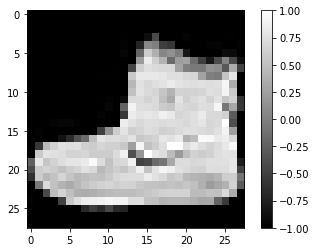

In [7]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

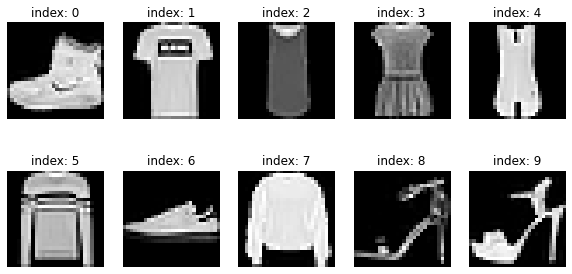

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

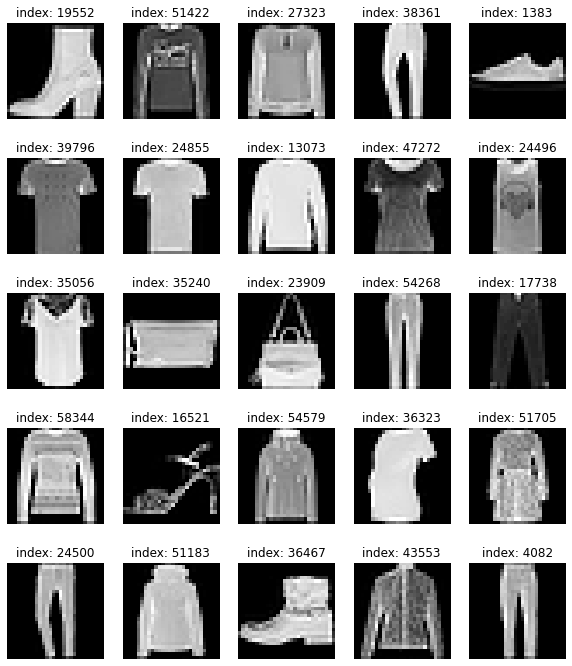

In [9]:
#랜덤으로 이미지 추출

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [10]:
#Dataset을 이용하면 매번 모델에게 직접 섞어서 넣어주지 않아도 됨.
BUFFER_SIZE = 60000   #BUFFER_SIZE은 전체 데이터를 섞기 위해 60,000으로 설정.
BATCH_SIZE = 256   #BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양.

In [11]:
#적절한 사이즈로 잘라서 학습을 진행하는 미니배치 학습 진행.
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

- 위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나눔.
- 데이터가 잘 섞이게 하기 위해 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋음.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있음.

### - GAN 모델
- 가장 간단한 형태의 생성 모델.
- 생성자, 판별자 두가지의 네트워크가 있음.
- 생성자(Generator) :  아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성.
- 판별자(Discriminator) : 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real인지, Fake인지에 대한 판단 정도를 실숫값으로 출력.

#### - DCGAN
- 합성곱 층(Convolutional Layer)으로 이루어진 딥러닝 모델.
- 이전의 GAN을 더욱 발전시켜서 훨씬 그럴듯한 고화질 이미지 생성을 이루어냄.

#### 생성자 구현

In [12]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

- Conv2DTranspose : 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층.
- 위 모델은 세 번의 Conv2DTranspose 층을 이용해 (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지를 키워나감.
- 최종사이즈인 (28,28,1)은 준비한 데이터셋과 형상이 동일함.
- BatchNormalization : 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜 줌.
- 중간층들의 활성화 함수는 모두 LeakyReLU를 사용.
- 지막 층에는 활성화 함수로 tanh를 사용 : -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함.
- 모델은 입력값으로 (batch_sieze, 100) 형상의 노이즈 벡터를 받음.
- 입력된 (batch_size, 100) 벡터는 7 x 7 x 256 = 12544개의 노드를 가진 첫 번째 Dense 레이어를 거치며 (batch_size, 12544) 형상의 벡터가 됨.

In [13]:
#생성모델
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [14]:
#shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성 해 결과물 도출.
#tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만듦.
noise = tf.random.normal([1, 100])

In [15]:
#Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에
#훈련 중이 아니니 training=False로 설정.
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

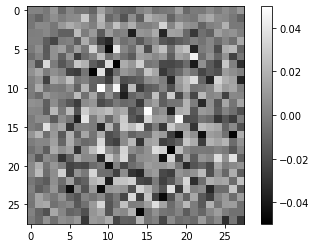

In [16]:
#matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정.
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

- 아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성.

#### 판별자 구현
- 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 함.

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

- 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나감.
- 첫 번째 Conv2D 층에서 입력된 [28, 28, 1] 사이즈의 이미지는 다음 층을 거치며 (28, 28, 1) → (14, 14, 64) → (7, 7, 128)까지 줄어들게 됨.
- 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환.
- 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력.

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [19]:
#위에서 생성했던 가짜 이미지를 판별자에 입력시켜 결과 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00134438]], dtype=float32)>

- 텐서플로우의 텐서 형태로 출력이 되며 이 값 또한 아직은 아무런 의미가 없는 값일 것.

### 모델 학습

#### 손실함수(loss function)
- GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용.
- 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰임.
- 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것.
- Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두면 각 손실함수를 이용해 정량적으로 달성해야 하는 목표는?
- 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것.
- 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것.

In [20]:
#tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정함.
#from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 
#함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있음.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용.
- fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
- real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

In [22]:
#tf.ones_like()와 tf.zeros_like() 함수를 활용해 fake_outpot과 real_output을 각 1과 0에 비교함
#이 함수들은 특정 벡터와 동일한 크기의 1 또는 0으로 이루어진 벡터 만들 때 사용.

vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

- 입력해 준 vector와 형태는 같지만, 그 내용물은 모두 1인 벡터가 만들어짐.

#### generator_loss
- fake_output가 1에 가까워지기를 바라므로 tf.ones_like와의 교차 엔트로피 값을 계산하면 됨.
- ross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가짐.

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### discriminator_loss
- real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산함.
- 최종 discriminator_loss 값은 이 둘을 더한 값.

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### discriminator accuracy

In [25]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

ex.) real_output = tf.Tensor(0.2, 0.4, 0.7, 0.9) 라면,

- (1) tf.math.greater_equal(real_output, tf.constant(0.5) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])
- (2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])
- (3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5

#### 최적화 함수(optimizer)
- Adam 최적화 기법을 활용.
- learning rate는 0.0001로 설정.
- 학습 품질 올리고 싶다면 여러 값으로 바꾸어 가며 학습 진행하는 것을 추천함.

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

- 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 함.

In [27]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

- 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인.
- 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어둠.

### 훈련 과정 설계
- 하나의 미니배치 당 진행할 train_step 함수를 먼저 만들어야 함.
- 학습시킬 훈련 함수 위에 @tf.function 이라는 데코레이터를 붙여서 사용.
- 이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해 줌.

In [28]:
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [29]:
import numpy as np
import tensorflow as tf

@tf.function    #위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었음.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

- @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환됨.

In [30]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- (1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator가
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [31]:
#샘플 생성하는 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [32]:
#train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 
#history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [33]:
#정기적으로 모델을 저장하기 위한 checkpoint
#checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장.
#생성자와 구분자가 학습한 모델 가중치를 저장.
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 모델 학습

In [34]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [35]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

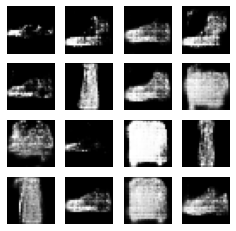

Time for training : 1574 sec


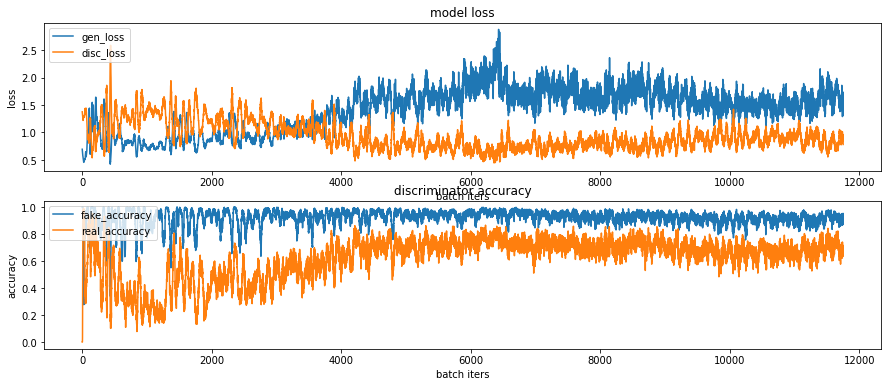

CPU times: user 7min 35s, sys: 53.1 s, total: 8min 28s
Wall time: 26min 15s


In [36]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

### 학습 과정 시각화

In [37]:
#샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만듦.
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1308347 Aug 26 07:08 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif
